# Twitter Sentiment Analysis using Spacy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import spacy
import string
import en_core_web_sm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


F:\ProgramFiles\Anaconda\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
data = pd.read_csv('Tweets.csv')
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [5]:
data.describe(include=['O'])

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


This gives a better idea of the dataset. Most of the tweets are negative and a majority of the complaints are about Customer Service issues. 

Most of the tweets are about the United Airlines. They could either be a bad review or good review. 

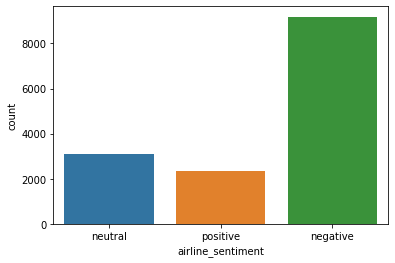

In [6]:
sns.countplot(x="airline_sentiment",data=data)

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


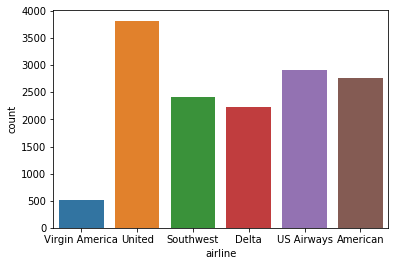

In [7]:
print(data['airline'].value_counts())
sns.countplot(x="airline",data=data)

airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152


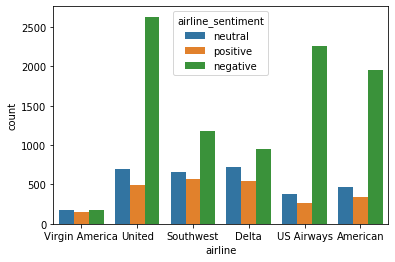

In [8]:
#print(data.groupby(["airline", "airline_sentiment"]).size())
print(pd.crosstab(data.airline,data.airline_sentiment))
sns.countplot(x="airline",hue="airline_sentiment", data=data)

This graphs shows that most of the tweets about United airline is negative. US Airways has also a high number of negative tweets followed by American Airways. 

Positive reviews are high for Southwest Airlines followed by delta Airlines.

In [9]:
data[data['airline_sentiment'] == 'negative' ]['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

Most of the Negative tweets are due to Customer service Issues followed by Delayed flights.

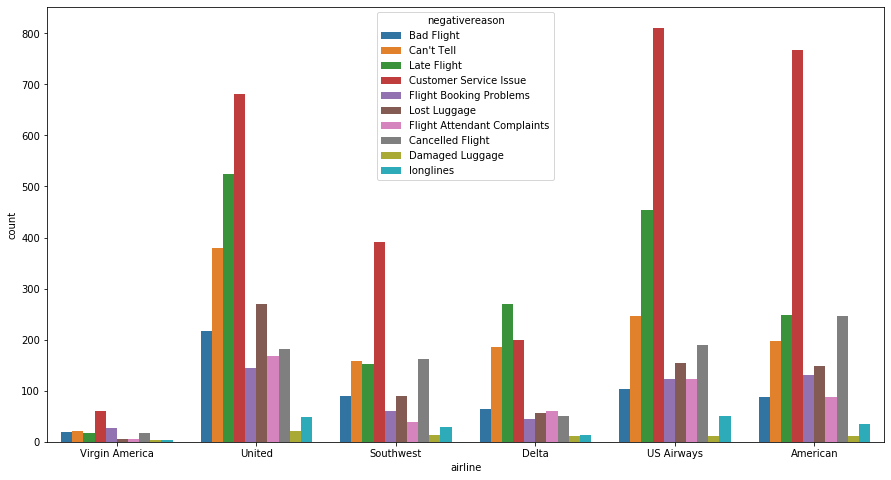

In [10]:
plt.figure(figsize=(15,8))
sns.countplot(x="airline",hue="negativereason", data=data)

In [11]:
data[data['airline_sentiment'] == 'positive' ]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)
11,570289724453216256,positive,1.0000,NaN,NaN,Virgin America,NaN,HyperCamiLax,NaN,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,NaN,2015-02-24 10:30:40 -0800,NYC,America/New_York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14623,569590013278756865,positive,0.6274,NaN,0.0,American,NaN,Flora_Lola_NYC,NaN,0,@AmericanAir Love the new planes for the JFK-L...,NaN,2015-02-22 12:10:16 -0800,NaN,Eastern Time (US & Canada)
14625,569589643487928321,positive,1.0000,NaN,NaN,American,NaN,DrCaseyJRudkin,NaN,0,@AmericanAir Flight 236 was great. Fantastic c...,"[40.64946781, -73.76624703]",2015-02-22 12:08:48 -0800,East Coast,NaN
14628,569588651925098496,positive,1.0000,NaN,NaN,American,NaN,jlhalldc,NaN,0,Thank you. “@AmericanAir: @jlhalldc Customer R...,NaN,2015-02-22 12:04:51 -0800,"Washington, DC",Eastern Time (US & Canada)
14630,569588473050611712,positive,1.0000,NaN,NaN,American,NaN,Laurelinesblog,NaN,0,@AmericanAir Thanks! He is.,NaN,2015-02-22 12:04:09 -0800,"Chapel Hill, NC",NaN


In [12]:
data['tweet_location'].value_counts().head(20)

Boston, MA           157
New York, NY         156
Washington, DC       150
New York             127
USA                  126
Chicago              104
New York City         96
Los Angeles, CA       96
NYC                   95
San Francisco, CA     91
San Francisco         86
Chicago, IL           81
Brooklyn, NY          66
Los Angeles           64
Austin, TX            64
Washington, D.C.      63
Boston                62
Dallas, TX            54
Washington DC         53
Nashville, TN         45
Name: tweet_location, dtype: int64

Most of the tweets are from users in Boston followed by New York and Washington

In [13]:
df = data[['text','airline_sentiment']]
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [14]:
nlp = en_core_web_sm.load()

F:\ProgramFiles\Anaconda\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


#### Data Prepocessing

This involves splitting up each row or text in the dataframe to tokens. Once the text is tokenized, we need to convert it into its lemma form. This process is called Lemmatization. Following lemmatization, we need to remove the stop words and punctuations from the text data.

In [17]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def tokenizer(text):
  
    # Splitting into tokens
    tokens = nlp(text)

    # Converting into its lemma
    tokens = [word.lemma_.strip() for word in tokens if word.lemma_ != "-PRON-" ]

    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations ]

    return tokens

#### Split the data to training and test data

In [18]:
X = data['text']
y = data['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


#### Convert data to its Vector format

In [19]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')


#### Classification Models

We can train the data using Suuport Vector Machine (SVM) called LinearSVC. 

In [23]:
svm = LinearSVC(random_state=1, dual=False, max_iter=10000)

Create a pipeline to do multiple tasks together 

In [24]:
pipe = Pipeline([
            ("vector_model",tf),
            ("svm",svm)])

pipe.fit(X_train,y_train)

y_predicted = pipe.predict(X_test)

#### Evaluation metrics

In [25]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predicted))
print("Recall:",metrics.recall_score(y_test, y_predicted,average="macro"))
print("Precision:",metrics.precision_score(y_test, y_predicted,average="macro"))

Accuracy: 0.7855191256830601
Recall: 0.699621922521059
Precision: 0.7351973265665376


#### Classification report

In [26]:
print("\n"+classification_report(y_test, y_predicted, target_names=["negative","neutral","positive"], digits=4))


              precision    recall  f1-score   support

    negative     0.8339    0.9047    0.8679      1826
     neutral     0.6408    0.5139    0.5704       611
    positive     0.7309    0.6802    0.7046       491

    accuracy                         0.7855      2928
   macro avg     0.7352    0.6996    0.7143      2928
weighted avg     0.7763    0.7855    0.7784      2928

